In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
CLINICAL_DATA = "../data/datasets/PCAWG/clinical_data/pcawg_donor_clinical_data.csv"
SURVIVAL_DATA = "../data/datasets/TCGA_data/TCGA_survival_outcome.csv"
CANCER_PATHWAYS = "../metadata/gene_pathways.csv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/ directories
HAZARD_PLOTS = "../results/hazard_plots"

if not os.path.exists(HAZARD_PLOTS):
	os.makedirs(HAZARD_PLOTS)
    
CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types with driver genes
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [4]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [5]:
# get all mutations in driver genes
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	print(cancer_type)
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	tumor_mut_cancer_df = tumor_mut_cancer_df[tumor_mut_cancer_df["gene"].isin(driver_genes_list)]
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")

	# get genome-wide mutation data
	genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
	tumor_mut_cancer_df["cancer_type"] = cancer_type
	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], ignore_index=True)
tumor_mut_df.head()

CNS-Oligo
Kidney-ChRCC
Prost-AdenoCA
Kidney-RCC
Stomach-AdenoCA
CNS-Medullo
Thy-AdenoCA
Myeloid-MPN
Bone-Leiomyo
Lymph-BNHL
Myeloid-AML
Lung-AdenoCA
CNS-GBM
Head-SCC
Breast-AdenoCa
Ovary-AdenoCA
CNS-PiloAstro
Cervix-SCC
Liver-HCC
Bone-Osteosarc
Biliary-AdenoCA
Skin-Melanoma
Lung-SCC
Lymph-CLL
Panc-Endocrine
Bladder-TCC
Panc-AdenoCA
ColoRect-AdenoCA
Breast-LobularCa
Eso-AdenoCa
Uterus-AdenoCA


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length,total_mutations,num_drivers,cancer_type,cna_burden
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,exonic,6.224800,33.0,35055,2778,5,CNS-Oligo,17.324180
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,exonic,5.575207,29.7,27261,2778,5,CNS-Oligo,17.324180
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,exonic,4.657281,25.4,27261,2778,5,CNS-Oligo,17.324180
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.4,29848,2778,5,CNS-Oligo,17.324180
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,exonic,8.096992,36.0,25760,3388,4,CNS-Oligo,19.993935


In [6]:
print(tumor_mut_df.shape)
# filter out samples that are not in the whitelist
tumor_mut_df = tumor_mut_df[tumor_mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(tumor_mut_df.shape)

(90258, 18)
(82512, 18)


In [7]:
# get clinical data
clinical_data_df = pd.read_csv(CLINICAL_DATA)
clinical_data_df = clinical_data_df[["icgc_donor_id", "submitted_donor_id", "donor_sex"]]
clinical_data_df = clinical_data_df.rename(columns={
    "icgc_donor_id": "Patient_ID", 
    "submitted_donor_id": "bcr_patient_barcode"
})
clinical_data_df.dropna(inplace=True)
clinical_data_df.drop_duplicates(inplace=True)
print(clinical_data_df.shape)
clinical_data_df.head()

(2809, 3)


,Patient_ID,bcr_patient_barcode,donor_sex
0,DO1000,CGP_donor_1114930,female
1,DO1001,CGP_donor_1069291,female
2,DO1002,CGP_donor_1114881,female
3,DO1003,CGP_donor_1114929,female
4,DO1004,CGP_donor_1167078,female


In [8]:
# get survival outcomes data
survival_data_df = pd.read_csv(SURVIVAL_DATA)
survival_data_df.reset_index(inplace=True)
survival_data_df.drop(columns=["index", "Unnamed: 0"], inplace=True)
print(survival_data_df.shape)
survival_data_df.head()

(11160, 33)


,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [9]:
# merge tumor data with clinical data
tumor_data_merged_df = pd.merge(tumor_mut_df, clinical_data_df, on="Patient_ID", how="left")
print(tumor_data_merged_df.shape)
tumor_data_merged_df.head()

(82512, 20)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,gene_length,total_mutations,num_drivers,cancer_type,cna_burden,bcr_patient_barcode,donor_sex
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,exonic,6.224800,33.0,35055,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,exonic,5.575207,29.7,27261,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,exonic,4.657281,25.4,27261,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,exonic,3.897263,23.4,29848,2778,5,CNS-Oligo,17.324180,TCGA-EZ-7264,female
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,exonic,8.096992,36.0,25760,3388,4,CNS-Oligo,19.993935,TCGA-FG-8182,male


In [10]:
# merge tumor data with survival data
tumor_survival_data_merged_df = pd.merge(tumor_data_merged_df, survival_data_df, on="bcr_patient_barcode", how="left")
print(tumor_survival_data_merged_df.shape)
tumor_survival_data_merged_df.head()

(82512, 52)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869:C:G,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826:T:C,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878:T:G,True,"mutational, CNA",True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112:C:T,True,mutational,True,...,NaN,0.0,1201.0,0.0,1201.0,NaN,NaN,0.0,1201.0,NaN
4,TP53,+,Nonsense_Mutation,2aeaab9f-4459-4be8-91e7-e0746cbd671c,DO22285,17:7574012-7574012:C:A,17:7574012:C:A,True,"mutational, CNA",True,...,NaN,0.0,416.0,0.0,416.0,NaN,NaN,0.0,416.0,NaN


## Hazard Model

In [21]:
event = "PFI"
event_time  = f"{event}.time"

# tumor samples for which we have survival data
tumor_survival_data_merged_df.dropna(subset=[event, event_time], inplace=True)
print(tumor_survival_data_merged_df.shape)

# mutation density by driver status
tumor_OS_df = tumor_survival_data_merged_df[~tumor_survival_data_merged_df["driver"]]
tumor_OS_mut_density = tumor_OS_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "mutation": "count",
    event: "first",
    event_time: "first",
    "num_drivers": "first",
    "cancer_type": "first",
    "age_at_initial_pathologic_diagnosis": "first",
    "donor_sex": "first",
    "cna_burden": "first",
    "total_mutations": "first",
}).reset_index()
tumor_OS_mut_density.rename(columns={
    "mutation": "num_passengers",
	"age_at_initial_pathologic_diagnosis": "age_at_diagnosis",
    "donor_sex": "sex",
}, inplace=True)
tumor_OS_mut_density.head()

(36659, 52)


,Tumor_Sample_Barcode,gene,has_driver,num_passengers,PFI,PFI.time,num_drivers,cancer_type,age_at_diagnosis,sex,cna_burden,total_mutations
0,00aa769d-622c-433e-8a8a-63fb5c41ea42,APC,True,8,0.0,255.0,18,ColoRect-AdenoCA,31.0,male,9.697974,237798
1,00aa769d-622c-433e-8a8a-63fb5c41ea42,ATM,True,8,0.0,255.0,18,ColoRect-AdenoCA,31.0,male,9.697974,237798
2,00aa769d-622c-433e-8a8a-63fb5c41ea42,FBXW7,False,11,0.0,255.0,18,ColoRect-AdenoCA,31.0,male,9.697974,237798
3,00aa769d-622c-433e-8a8a-63fb5c41ea42,KRAS,True,4,0.0,255.0,18,ColoRect-AdenoCA,31.0,male,9.697974,237798
4,00aa769d-622c-433e-8a8a-63fb5c41ea42,PIK3CA,True,4,0.0,255.0,18,ColoRect-AdenoCA,31.0,male,9.697974,237798


In [22]:
cancer_types = tumor_OS_mut_density.groupby("cancer_type").agg({
    "Tumor_Sample_Barcode": "nunique",
}).reset_index()
cancer_types.rename(columns={
	"Tumor_Sample_Barcode": "num_samples",
}, inplace=True)
cancer_types.sort_values("num_samples", ascending=False, inplace=True)
cancer_types.reset_index(drop=True, inplace=True)
print(cancer_types.shape)
cancer_types

(21, 2)


,cancer_type,num_samples
0,Breast-AdenoCa,84
1,Kidney-RCC,69
2,Liver-HCC,53
3,ColoRect-AdenoCA,52
4,Lung-SCC,47
5,Uterus-AdenoCA,44
6,Head-SCC,43
7,Ovary-AdenoCA,38
8,Skin-Melanoma,37
9,Stomach-AdenoCA,35


In [23]:
cancer_type = "Liver-HCC"
patient_data = tumor_OS_mut_density[(tumor_OS_mut_density["cancer_type"] == cancer_type)]
patient_data = patient_data[["Tumor_Sample_Barcode", event, event_time, "age_at_diagnosis", "sex", "num_drivers", "cna_burden", "total_mutations"]]
patient_data["sex"] = patient_data["sex"].apply(lambda x: 0 if x == "female" else 1)
patient_data.dropna(inplace=True)
print(patient_data.shape)
patient_data.drop_duplicates(inplace=True)
print(patient_data.shape)
patient_data.head()

(173, 8)
(53, 8)


,Tumor_Sample_Barcode,PFI,PFI.time,age_at_diagnosis,sex,num_drivers,cna_burden,total_mutations
30,03c88506-d72e-4a44-a34e-a7f0564f1799,1.0,430.0,77.0,1,1,42.948840,9597
130,0d259ac2-03d1-4814-9b0b-d05e3a6029b7,1.0,320.0,73.0,1,1,31.918422,8333
188,1127b561-ea40-4d5e-95df-daa0a5ebc1e4,0.0,585.0,61.0,1,5,14.836100,18071
304,1c00925b-7328-4db0-b930-04aab2d80719,1.0,102.0,26.0,0,2,97.320292,10197
422,29b92b51-7ba3-42a9-97d3-6a9b5e43f928,1.0,144.0,67.0,1,1,47.476117,16750


In [24]:
gene_data = tumor_OS_mut_density[(tumor_OS_mut_density["cancer_type"] == cancer_type)]
gene_data = gene_data[["Tumor_Sample_Barcode", "gene", "num_passengers", "has_driver", "total_mutations"]]
gene_data.drop(columns=["total_mutations"], inplace=True)
print(gene_data.shape)
gene_data.dropna(inplace=True)
print(gene_data.shape)

# genes with atleast 10 samples having passenger mutations
# 
gene_mut_count = gene_data[gene_data["num_passengers"] > 0].groupby("gene").agg({
    "Tumor_Sample_Barcode": "nunique",
    
}).reset_index()
gene_mut_count.rename(columns={
	"Tumor_Sample_Barcode": "num_samples",
}, inplace=True)
gene_list = gene_mut_count[gene_mut_count["num_samples"] >= 10]["gene"].tolist()
print(len(gene_list), gene_list)
gene_data = gene_data[gene_data["gene"].isin(gene_list)]

gene_data["has_driver"] = gene_data["has_driver"].apply(lambda x: 1 if x else 0)
gene_data = gene_data.pivot(index="Tumor_Sample_Barcode", columns="gene", values=["num_passengers", "has_driver"])
gene_data.columns = [f"{col[1]}_{col[0]}" for col in gene_data.columns]
gene_data.reset_index(inplace=True)
gene_data.fillna(0, inplace=True)
gene_data.drop_duplicates(inplace=True)
print(gene_data.shape)
gene_data.head()
gene_mut_count

(173, 4)
(173, 4)
6 ['APC', 'ARID1A', 'ARID2', 'CSMD3', 'NFE2L2', 'RB1']
(53, 13)


,gene,num_samples
0,APC,20
1,ARID1A,10
2,ARID2,18
3,AXIN1,5
4,CSMD3,53
5,CTNNB1,9
6,KEAP1,2
7,NFE2L2,21
8,RANBP2,6
9,RB1,14


In [25]:
model_data = pd.merge(patient_data, gene_data, on="Tumor_Sample_Barcode", how="left")
model_data.drop(columns=["Tumor_Sample_Barcode"], inplace=True)
print(model_data.shape)
# remove columns that have same value for all rows
model_data = model_data.loc[:, (model_data != model_data.iloc[0]).any()]
print(model_data.shape)
# # split columns with large number of values into quantiles
# labels = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]
# for col in model_data.columns:
# 	if "num_passengers" in col and model_data[col].nunique() > 5:
# 		model_data[col] = pd.qcut(model_data[col], q=5, labels=labels)
# 		model_data[col] = model_data[col].astype("category")
print(model_data.shape)

model_data.head()

(53, 19)
(53, 14)
(53, 14)


,PFI,PFI.time,age_at_diagnosis,sex,num_drivers,cna_burden,total_mutations,APC_num_passengers,ARID1A_num_passengers,ARID2_num_passengers,CSMD3_num_passengers,NFE2L2_num_passengers,RB1_num_passengers,ARID1A_has_driver
0,1.0,430.0,77.0,1,1,42.948840,9597,1.0,0.0,0.0,8.0,0.0,0.0,0.0
1,1.0,320.0,73.0,1,1,31.918422,8333,1.0,0.0,0.0,21.0,0.0,1.0,0.0
2,0.0,585.0,61.0,1,5,14.836100,18071,1.0,1.0,0.0,6.0,4.0,2.0,0.0
3,1.0,102.0,26.0,0,2,97.320292,10197,0.0,1.0,0.0,12.0,2.0,1.0,0.0
4,1.0,144.0,67.0,1,1,47.476117,16750,0.0,1.0,2.0,15.0,0.0,0.0,0.0


In [26]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(model_data, duration_col = event_time, event_col = event)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 53 total observations, 30 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 53
number of events observed = 23
   partial log-likelihood = -57.05
         time fit was run = 2025-05-24 21:03:28 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age_at_diagnosis       -0.06       0.94       0.02            -0.10            -0.02                 0.90                 0.98
sex                    -1.72       0.18       0.63            -2.95            -0.48                 0.05                 0.62
num_drivers             0.41       1.51       0.30            -0.17             1.00                 0.85                 2.71
cna_burden              0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
total_mutations        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
APC_num_passengers     -0.14       0.87       0.53            -1.18             0.89                 0.31                 2.45
ARID1A_num_passengers  -0.24       0.78       0.82            -1.86             1.37                 0.16                 3.94
ARID2_num_passengers    2.38      10.80       0.67             1.07             3.69                 2.92                40.00
CSMD3_num_passengers    0.17       1.19       0.05             0.07             0.27                 1.07                 1.31
NFE2L2_num_passengers   0.53       1.70       0.39            -0.23             1.30                 0.79                 3.66
RB1_num_passengers     -0.30       0.74       0.46            -1.20             0.61                 0.30                 1.84
ARID1A_has_driver      -0.00       1.00     100.00          -196.00           196.00                 0.00             1.32e+85

                        cmp to     z      p   -log2(p)
covariate                                             
age_at_diagnosis          0.00 -2.88 <0.005       7.96
sex                       0.00 -2.71   0.01       7.23
num_drivers               0.00  1.40   0.16       2.63
cna_burden                0.00  0.57   0.57       0.81
total_mutations           0.00 -2.87 <0.005       7.92
APC_num_passengers        0.00 -0.27   0.78       0.35
ARID1A_num_passengers     0.00 -0.29   0.77       0.38
ARID2_num_passengers      0.00  3.56 <0.005      11.41
CSMD3_num_passengers      0.00  3.32 <0.005      10.13
NFE2L2_num_passengers     0.00  1.37   0.17       2.54
RB1_num_passengers        0.00 -0.64   0.52       0.94
ARID1A_has_driver         0.00 -0.00   1.00       0.00
---
Concordance = 0.81
Partial AIC = 138.10
log-likelihood ratio test = 30.87 on 12 df
-log2(p) of ll-ratio test = 8.92

In [27]:
# get significant features
threshold = 0.05
# # multiple testing correction
# from statsmodels.stats.multitest import multipletests
# pvals = cph.summary["p"].values
# reject, pvals_corrected, _, _ = multipletests(pvals, alpha=threshold, method='fdr_bh')
significant_features = cph.summary[cph.summary["p"] < threshold].index.tolist()
print(len(significant_features), significant_features)
sig_genes = cph.summary.reset_index()
sig_genes[["covariate", "coef", "exp(coef)", "p"]][sig_genes["p"] < threshold]

5 ['age_at_diagnosis', 'sex', 'total_mutations', 'ARID2_num_passengers', 'CSMD3_num_passengers']


,covariate,coef,exp(coef),p
0,age_at_diagnosis,-0.060823,0.940990,0.004021
1,sex,-1.715398,0.179892,0.006657
4,total_mutations,-0.000157,0.999843,0.004142
7,ARID2_num_passengers,2.379594,10.800517,0.000368
8,CSMD3_num_passengers,0.170049,1.185363,0.000894


In [28]:
cph.check_assumptions(model_data)

Proportional hazard assumption looks okay.


[]

<Axes: xlabel='log(HR) (95% CI)'>

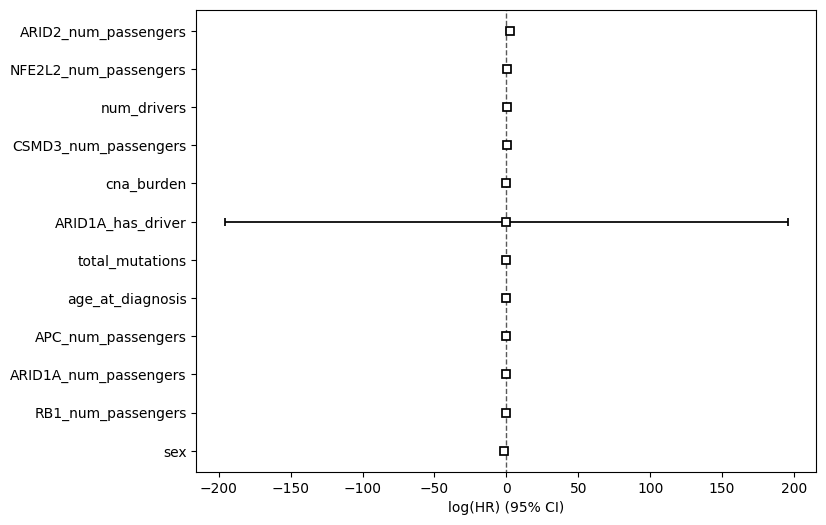

In [29]:
plt.subplots(figsize = (8, 6))
cph.plot()

[ 1.    6.5  13.5  20.75 54.  ]


<Figure size 700x600 with 0 Axes>

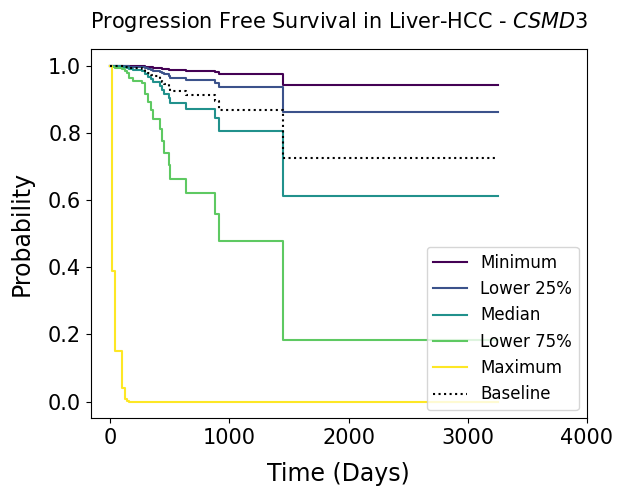

In [31]:
feature = "CSMD3_num_passengers"
vals = model_data[feature].unique()
vals.sort()
vals = vals[~np.isnan(vals)]
vals = [int(val) for val in vals]
if len(vals) > 5:
	# get quartiles
	quintiles = np.percentile(vals, [0, 25, 50, 75, 100])
	print(quintiles)
plt.figure(figsize=(7, 6))
cph.plot_partial_effects_on_outcome(
    covariates=feature, 
    values=quintiles if len(vals) > 5 else vals,
    cmap="viridis",
    plot_baseline=True,
)
event_title = "Overall Survival" if event == "OS" else "Progression Free Survival"
plt.xlabel("Time (Days)", fontsize=17, labelpad=10)
plt.ylabel("Probability", fontsize=17, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, ticks=np.arange(0, 4001, 1000)) # limit xticks to 5
plt.title(f"{event_title} in {cancer_type} - $\it{{{feature.split('_')[0]}}}$", fontsize=15, pad=15)
if len(vals) > 5:
	labels = ["Minimum", "Lower 25%", "Median", "Lower 75%", "Maximum", "Baseline"]
	# plt.legend(loc="lower right", labels=labels, fontsize=15, bbox_to_anchor=(1.43, 0.45))
	plt.legend(loc="lower right", labels=labels, fontsize=12, bbox_to_anchor=(1, 0.0))
else:
	# plt.legend(loc="lower right", fontsize=15, bbox_to_anchor=(1.2, 0.5))
	plt.legend(loc="lower right", fontsize=12, bbox_to_anchor=(1, 0.25))
plt.savefig(f"../results/partial_effects_{cancer_type}_{feature}.pdf", bbox_inches="tight")